# Predicting fluxes from transcripts using a random forest

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import r2_score
from scipy.stats import spearmanr, pearsonr
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, cross_val_predict, ShuffleSplit
from tpot import TPOTRegressor
import seaborn as sns
import random
%matplotlib inline

/usr/local/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Load input files

In [2]:
# Load reaction names
reactionNames = np.loadtxt('ishii-flux-names.csv',delimiter=',', skiprows=0,usecols=0,dtype='str')

In [3]:
# Select flux indicies for plotting
reactionDict = {'PGI':2076,'PFK':2063,'FBA':1150,'TPI':2455,'PYK':2265,'PDH':2046,'GND':1422,'RPE':2311,'RPI':2312,'TALA':2397,'ICL':1551,'MALS':1713}
ishiiDict = {2076:2.247179186,2063:2.495301258,1150:2.495301258,2455:2.495301258,2265:1.399624166,2046:3.722827564,1422:.6439079794,2311:.2684455913,2312:.3754514687,2397:.1783978343,1551:.3268244693,1713:.3268244693}

In [4]:
# Load train and test data
# Training data is from eflux2 samples 2 to 8, representing different KEIO KO strains and growth conditions
# Test data is eflux2 sample1, the WT reference sample
train_x, train_y = [],[]
for i in range(2,9):
    train_x.append(np.loadtxt('ishii-trans-'+str(i)+'.csv',delimiter=',',skiprows=0,usecols=1))
    train_y.append(np.loadtxt('ishii-flux-'+str(i)+'.csv'))
test_x, test_y = np.loadtxt('ishii-trans-1.csv',delimiter=',',skiprows=0,usecols=1),np.loadtxt('ishii-flux-1.csv')
train_x, train_y = np.array(train_x), np.array(train_y)

# Define and run random forest

In [5]:
# Load data into arrays for plotting
rfArray, eflux2, absError = [],[],[]
eflux2Fluxes = test_y
for r in reactionDict:
    # Define type of random forest
    rf = RandomForestRegressor(n_estimators=20, oob_score=False, random_state=0,n_jobs=-1,max_features=10,max_leaf_nodes=10)
    rf.fit(train_x, train_y[:,reactionDict[r]])
    # Use the forest's predict method on the test data
    predictions = rf.predict(test_x.reshape(1, -1))
    i = reactionDict[r]
    print('Working on reaction:',reactionNames[i])
    print('   Random Forest:',predictions[0],'|   Eflux2 prediction:',test_y[i])
    rfArray.append(predictions[0])
    eflux2.append(float(test_y[i]))
    absError.append(abs(predictions[0]-float(test_y[i])))
rfArray = np.array(rfArray)
eflux2 = np.array(eflux2)

Working on reaction: R_PGI
   Random Forest: 2.1997226038 |   Eflux2 prediction: 2.296128682
Working on reaction: R_PFK
   Random Forest: 2.18585135165 |   Eflux2 prediction: 1.790151679
Working on reaction: R_FBA
   Random Forest: 2.18585135165 |   Eflux2 prediction: 1.790151679
Working on reaction: R_TPI
   Random Forest: 3.9431097148499994 |   Eflux2 prediction: 3.378207362
Working on reaction: R_PYK
   Random Forest: 2.8892026101500003 |   Eflux2 prediction: 1.563415101
Working on reaction: R_PDH
   Random Forest: 0.7353710447105517 |   Eflux2 prediction: 1.100181514
Working on reaction: R_GND
   Random Forest: 2.0001336756 |   Eflux2 prediction: 1.691451557
Working on reaction: R_RPE
   Random Forest: 1.06972875095 |   Eflux2 prediction: 0.867799311
Working on reaction: R_RPI
   Random Forest: -0.9028449135999999 |   Eflux2 prediction: -0.810324773
Working on reaction: R_TALA
   Random Forest: -1.0117974969999997 |   Eflux2 prediction: -0.861606754
Working on reaction: R_ICL
   Ra

In [6]:
# Load reaction labels
labels=[i for i in reactionDict]

# Plot results

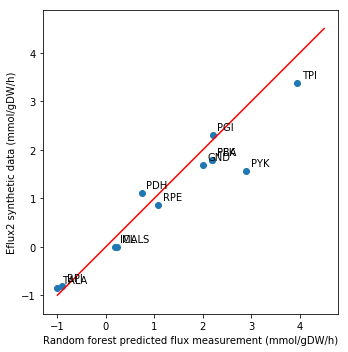

In [7]:
# Plot scatter plot of fluxes
plt.rcParams['figure.figsize'] = (5,5)
plt.scatter(rfArray,eflux2,label=labels)
X_plot = np.linspace(-1, 4.5, 100)
Y_plot = X_plot
plt.plot(X_plot, Y_plot, color='r')
plt.xlim(-1,3)
plt.axis('equal')
for i in range(len(rfArray)):
    xy = (rfArray[i]+.1,eflux2[i]+.1)
    plt.annotate(labels[i],xy)
plt.xlabel(r'Random forest predicted flux measurement (mmol/gDW/h)')
plt.ylabel(r'Eflux2 synthetic data (mmol/gDW/h)')
plt.tight_layout()
#plt.show()
plt.savefig('rf-eflux2.pdf')

/usr/local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


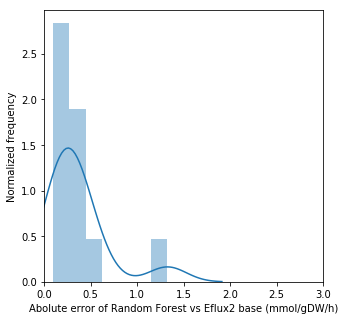

In [8]:
# Histogram plot of errors
g=sns.distplot(absError,hist=True)
plt.xlabel(r'Abolute error of Random Forest vs Eflux2 base (mmol/gDW/h)')
plt.ylabel(r'Normalized frequency')
plt.xlim(0,3)
#plt.show()
plt.savefig('rf-eflux2-error.pdf')

/usr/local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


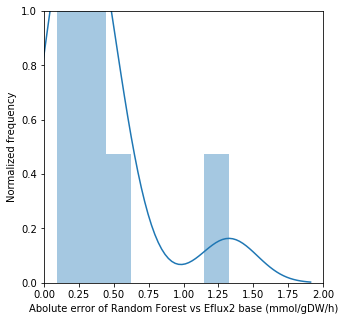

In [9]:
# Zoom of histogram error
g=sns.distplot(absError,hist=True)
plt.xlabel(r'Abolute error of Random Forest vs Eflux2 base (mmol/gDW/h)')
plt.ylabel(r'Normalized frequency')
plt.xlim(0,2)
plt.ylim(0,1)
#plt.show()
plt.savefig('rf-eflux2-error-zoom.pdf')

# Define and run random forest for all metabolic reactions

Now let's run random foreset on all reactions to look at histogram of absolute error:

In [10]:
# Load data into arrays for plotting
rfArray, eflux2, absError = [],[],[]
eflux2Fluxes = test_y
for r in range(len(reactionNames)):
    # Define type of random forest
    rf = RandomForestRegressor(n_estimators=20, oob_score=False, random_state=0,n_jobs=-1,max_features=10,max_leaf_nodes=10)
    rf.fit(train_x, train_y[:,r])
    # Use the forest's predict method on the test data
    predictions = rf.predict(test_x.reshape(1, -1))
    i = r
    print('Working on reaction:',reactionNames[i])
    print('   Random Forest:',predictions[0],'|   Eflux2 prediction:',test_y[i])
    rfArray.append(predictions[0])
    eflux2.append(float(test_y[i]))
    absError.append(abs(predictions[0]-float(test_y[i])))
rfArray = np.array(rfArray)
eflux2 = np.array(eflux2)

Working on reaction: R_DM_4CRSOL
   Random Forest: 7.058428571428573e-05 |   Eflux2 prediction: 7.47e-05
Working on reaction: R_DM_5DRIB
   Random Forest: 7.121214285714286e-05 |   Eflux2 prediction: 7.53e-05
Working on reaction: R_DM_AACALD
   Random Forest: 1.436857142857143e-15 |   Eflux2 prediction: 8.65e-16
Working on reaction: R_DM_AMOB
   Random Forest: 6.330928571428571e-07 |   Eflux2 prediction: 6.7e-07
Working on reaction: R_DM_MTHTHF
   Random Forest: 0.00014169999999999997 |   Eflux2 prediction: 0.00015
Working on reaction: R_DM_OXAM
   Random Forest: 2.904466428571428e-13 |   Eflux2 prediction: 7.38e-12
Working on reaction: R_Ec_biomass_iJO1366_WT_53p95M
   Random Forest: 6.894428571428571e-17 |   Eflux2 prediction: 1.1e-15
Working on reaction: R_Ec_biomass_iJO1366_core_53p95M
   Random Forest: 0.3230203953 |   Eflux2 prediction: 0.334827489
Working on reaction: R_EX_12ppd_DASH_R_LPAREN_e_RPAREN_
   Random Forest: 4.225843571428571e-12 |   Eflux2 prediction: 7.22e-11
Worki

# Plot results

/usr/local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


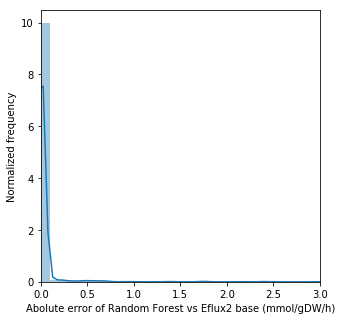

In [11]:
# Histogram plot of errors
g=sns.distplot(absError,hist=True)
plt.xlabel(r'Abolute error of Random Forest vs Eflux2 base (mmol/gDW/h)')
plt.ylabel(r'Normalized frequency')
plt.xlim(0,3)
#plt.show()
plt.savefig('rf-eflux2-allReactions-error.pdf')

/usr/local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


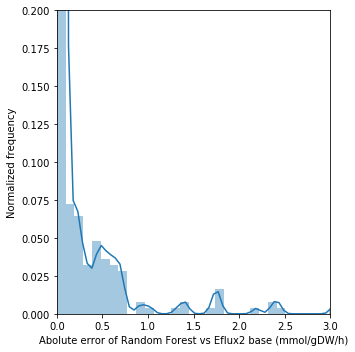

In [12]:
# Zoom of histogram error
g=sns.distplot(absError,hist=True)
plt.xlabel(r'Abolute error of Random Forest vs Eflux2 base (mmol/gDW/h)')
plt.ylabel(r'Normalized frequency')
plt.xlim(0,3)
plt.ylim(0,.2)
#plt.show()
plt.tight_layout()
plt.savefig('rf-eflux2-allReactions-error-zoom.pdf')